# Supervised Learning: Predicting Depression Severity

This notebook implements three supervised learning models to predict depression severity, measured by the PHQ-9 total score (`PHQ9_TOTAL`). The input dataset, `merged_clean_sl.csv`, contains cleaned binary, ordinal, and continuous variables selected from the 2021–2023 NHANES questionnaire modules.

## Modeling Overview

Three models are trained and evaluated:
- Logistic Regression  
- Random Forest  
- Support Vector Machine (SVM)

All models use a common set of 19 predictors. These include:
- Demographics (e.g., age, household size)
- Socioeconomic factors (e.g., poverty index, education, insurance coverage)
- Health access and behaviors (e.g., usual care source, mental health visits)
- Sleep and self-reported anxiety

Features were selected based on prior clustering results and domain relevance to depression risk. No one-hot encoding is used. Evaluation will use cross-validation with metrics such as accuracy, F1 score, and ROC-AUC (if classification).

The top-performing model will include:
- Feature importance analysis  
- Sensitivity or ablation study  
- Discussion of performance tradeoffs

Failure analysis will identify at least three common prediction errors and explore possible causes.


In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
import pandas as pd

# Load the dataset
df = pd.read_csv("../data/clean/merged_clean_sl.csv")

# Show the first few rows
df.head()

,Gender,Age in years at screening,Education level - Adults 20+,Total number of people in the Household,Difficulty these problems have caused,Difficulty with self-care,How often feel worried/nervous/anxious,Level of feeling worried/nervous/anxious,Covered by health insurance,Covered by private insurance,...,Covered by state-sponsored health plan,Time when no insurance in past year?,Routine place to go for healthcare,Type place most often go for healthcare,Past 12 months had video conf w/Dr?,Seen mental health professional/past yr,Monthly poverty index,Sleep hours - weekdays or workdays,Sleep hours - weekends,PHQ9_TOTAL
0,1,33,3,3,2,1,1,2,1,0,...,0,0,1,1,0,0,0.94,7.5,7.5,24.0
1,1,67,3,2,0,1,1,3,1,1,...,0,0,1,1,0,0,3.28,8.0,8.0,8.0
2,0,67,1,1,1,2,1,2,0,0,...,0,0,1,1,0,0,NaN,6.0,6.0,11.0
3,1,38,5,1,1,1,1,3,1,1,...,0,0,1,1,1,1,5.00,8.5,13.5,14.0
4,1,66,4,4,1,1,1,2,0,0,...,0,0,0,0,0,0,NaN,6.0,8.0,8.0


## Target Variable Setup

To support both regression and classification models, two target versions will be created:

- `target_reg`: the original PHQ-9 total score, used for regression
- `target_cls`: a binned version of PHQ-9, used for classification

The classification bins follow standard PHQ-9 severity thresholds:
- 0–4: None/minimal
- 5–9: Mild
- 10–14: Moderate
- 15–19: Moderately severe
- 20–27: Severe

These categories are commonly used in clinical research and public health.


In [3]:
# Keep a copy of the original score for regression
df["target_reg"] = df["PHQ9_TOTAL"]

# Bin PHQ-9 scores into standard severity categories for classification
bins = [-1, 4, 9, 14, 19, 27]
labels = ["None/Minimal", "Mild", "Moderate", "Moderately Severe", "Severe"]
df["target_cls"] = pd.cut(df["PHQ9_TOTAL"], bins=bins, labels=labels)


In [4]:
# List of predictor column names
predictors = [
    "Age in years at screening",
    "Monthly poverty index",
    "Total number of people in the Household",
    "Education level - Adults 20+",
    "Covered by health insurance",
    "Covered by private insurance",
    "Covered by Medicare",
    "Covered by Medi-Gap",
    "Covered by Medicaid",
    "Covered by military health care",
    "Covered by state-sponsored health plan",
    "Time when no insurance in past year?",
    "Seen mental health professional/past yr",
    "Past 12 months had video conf w/Dr?",
    "Routine place to go for healthcare",
    "Type place most often go for healthcare",
    "Sleep hours - weekdays or workdays",
    "Sleep hours - weekends",
    "How often feel worried/nervous/anxious"
]

# Check missing values in predictors
missing_predictors = df[predictors].isnull().sum()

# Check missing values in targets
missing_target_reg = df["target_reg"].isnull().sum()
missing_target_cls = df["target_cls"].isnull().sum()

print("Missing values in predictors:\n", missing_predictors)
print("\nMissing values in regression target:", missing_target_reg)
print("Missing values in classification target:", missing_target_cls)


Missing values in predictors:
 Age in years at screening                   0
Monthly poverty index                      91
Total number of people in the Household     0
Education level - Adults 20+                0
Covered by health insurance                 0
Covered by private insurance                0
Covered by Medicare                         0
Covered by Medi-Gap                         0
Covered by Medicaid                         0
Covered by military health care             0
Covered by state-sponsored health plan      0
Time when no insurance in past year?        0
Seen mental health professional/past yr     0
Past 12 months had video conf w/Dr?         0
Routine place to go for healthcare          0
Type place most often go for healthcare     0
Sleep hours - weekdays or workdays         10
Sleep hours - weekends                     11
How often feel worried/nervous/anxious      0
dtype: int64

Missing values in regression target: 0
Missing values in classification target: 0

## Handling Missing Values

Only three predictors have missing values:

- Monthly poverty index: 91 missing
- Sleep hours – weekdays or workdays: 10 missing
- Sleep hours – weekends: 11 missing

All missing values are handled using median imputation to preserve as many records as possible without introducing bias from mean-based or model-based estimates.


In [5]:
# Median imputation for numeric predictors
df["Monthly poverty index"] = df["Monthly poverty index"].fillna(df["Monthly poverty index"].median())
df["Sleep hours - weekdays or workdays"] = df["Sleep hours - weekdays or workdays"].fillna(df["Sleep hours - weekdays or workdays"].median())
df["Sleep hours - weekends"] = df["Sleep hours - weekends"].fillna(df["Sleep hours - weekends"].median())


## Train/Test Split

The predictor matrix (`X`) includes all 19 selected features. Separate targets are used for classification (`target_cls`) and regression (`target_reg`).

For classification, a stratified 80/20 train-test split is used to maintain the original distribution of PHQ-9 severity categories. For regression, a standard 80/20 split is applied without stratification.


In [6]:
from sklearn.model_selection import train_test_split

# Define feature matrix
X = df[predictors]

# Classification target
y_cls = df["target_cls"]

# Regression target
y_reg = df["target_reg"]

# Stratified split for classification
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(
    X, y_cls, test_size=0.2, random_state=42, stratify=y_cls
)

# Standard split for regression
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X, y_reg, test_size=0.2, random_state=42
)


### Cross-Validation Setup

To evaluate model performance more reliably, all classification models are assessed using stratified 5-fold cross-validation. This preserves the distribution of PHQ-9 severity categories across training folds and provides more stable performance estimates. Hyperparameter tuning is performed using GridSearchCV with this cross-validation strategy. The test set is held out and used only for final evaluation.


### Hyperparameter Strategy and Ethical Rationale

Each model uses a targeted grid of hyperparameters that balances accuracy, interpretability, and fairness:

- **Class weighting** is included to reduce bias against smaller groups like Severe or Moderately Severe.
- **Tree depth and leaf size** are constrained to prevent overfitting to rare mental health profiles.
- **Regularization and margin control** help generalize across patient groups with different risk factors.
- **Bootstrap sampling** (Random Forest) preserves data diversity without depending on individual cases.
- **Kernel and gamma tuning** (SVM) adds flexibility while keeping complexity in check.

These choices were made with transparency in mind — prioritizing responsible generalization, not chasing marginal performance gains. No black-box tuning was used.


### Logistic Regression (Classification)

Logistic Regression is used to predict PHQ-9 severity categories. It is a baseline model that is interpretable and efficient. All features are standardized prior to modeling. Hyperparameters are tuned using stratified 5-fold cross-validation on the training data only. The final model is evaluated on a held-out test set.

---

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
import matplotlib.pyplot as plt

# Create pipeline
logreg_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(max_iter=1000, random_state=42))
])

# Set stratified 5-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Hyperparameter grid
param_grid_logreg = {
    "logreg__C": [0.001, 0.01, 0.1, 1, 10, 100],  # smaller C = stronger regularization
    "logreg__penalty": ["l2"],                   # standard penalty for stability
    "logreg__solver": ["lbfgs"],                 # supports multiclass with l2
    "logreg__class_weight": [None, "balanced"]   # adjust for imbalanced classes
}

# GridSearchCV
grid_logreg = GridSearchCV(
    estimator=logreg_pipeline,
    param_grid=param_grid_logreg,
    cv=cv,
    scoring="f1_weighted",
    n_jobs=-1
)

# Fit grid search on training data only
grid_logreg.fit(X_train_cls, y_train_cls)

# Best parameters
print("Best Logistic Regression Params:", grid_logreg.best_params_)


Best Logistic Regression Params: {'logreg__C': 0.1, 'logreg__class_weight': None, 'logreg__penalty': 'l2', 'logreg__solver': 'lbfgs'}


                   precision    recall  f1-score   support

             Mild       0.28      0.27      0.27        30
         Moderate       0.37      0.53      0.43        38
Moderately Severe       0.20      0.11      0.14        18
           Severe       0.00      0.00      0.00         8

         accuracy                           0.32        94
        macro avg       0.21      0.23      0.21        94
     weighted avg       0.28      0.32      0.29        94



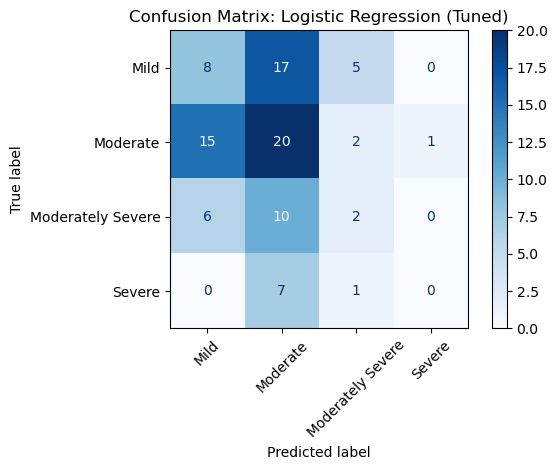

Test ROC-AUC (OvR, macro): 0.563


In [8]:
# Evaluate on test set using best estimator
best_logreg_model = grid_logreg.best_estimator_
y_pred_logreg = best_logreg_model.predict(X_test_cls)
y_proba_logreg = best_logreg_model.predict_proba(X_test_cls)

# Classification report
print(classification_report(y_test_cls, y_pred_logreg))

# Confusion matrix
cm_logreg = confusion_matrix(y_test_cls, y_pred_logreg, labels=best_logreg_model.classes_)
disp_logreg = ConfusionMatrixDisplay(confusion_matrix=cm_logreg, display_labels=best_logreg_model.classes_)
disp_logreg.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix: Logistic Regression (Tuned)")
plt.tight_layout()
plt.show()

# ROC-AUC score (macro average)
auc_logreg = roc_auc_score(y_test_cls, y_proba_logreg, multi_class="ovr", average="macro")
print(f"Test ROC-AUC (OvR, macro): {auc_logreg:.3f}")


### Logistic Regression Performance Summary

The tuned Logistic Regression model used an `l2` penalty, `C=0.1`, and no class weighting. It achieved:

- **Accuracy**: 0.32  
- **Weighted F1 Score**: 0.29  
- **ROC-AUC (macro average)**: 0.563

The model showed moderate success classifying Mild and Moderate depression levels but struggled with more severe categories. Severe cases were consistently underidentified, and most misclassifications clustered around adjacent classes. This suggests the linear boundary is not flexible enough to distinguish overlapping symptom profiles in higher-risk groups.


### Random Forest (Classification)

Random Forest is a non-parametric ensemble model that can capture nonlinear interactions and rank feature importance. It is well-suited for imbalanced, high-dimensional health data. Hyperparameters are tuned using stratified 5-fold cross-validation on the training set. The final model is evaluated on a held-out test set.


In [9]:
from sklearn.ensemble import RandomForestClassifier

# Define parameter grid for tuning
param_grid_rf = {
    "n_estimators": [100, 300, 500],               # number of trees in the forest
    "max_depth": [None, 10, 20, 40],               # limits how deep trees can grow
    "min_samples_split": [2, 5, 10],               # min samples needed to split a node
    "min_samples_leaf": [1, 2, 4],                 # min samples in a leaf to prevent overfitting
    "bootstrap": [True],                           # use sampling with replacement (default)
    "class_weight": [None, "balanced_subsample"]   # balance class weights during training
}

# Initialize model
rf_classifier = RandomForestClassifier(random_state=42)

# GridSearchCV with stratified 5-fold CV
grid_rf = GridSearchCV(
    estimator=rf_classifier,
    param_grid=param_grid_rf,
    cv=cv,
    scoring="f1_weighted",
    n_jobs=-1
)

# Fit grid search on training data only
grid_rf.fit(X_train_cls, y_train_cls)

# Print best hyperparameters
print("Best Random Forest Params:", grid_rf.best_params_)


Best Random Forest Params: {'bootstrap': True, 'class_weight': 'balanced_subsample', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}


                   precision    recall  f1-score   support

             Mild       0.16      0.17      0.16        30
         Moderate       0.32      0.34      0.33        38
Moderately Severe       0.38      0.33      0.35        18
           Severe       0.17      0.12      0.14         8

         accuracy                           0.27        94
        macro avg       0.26      0.24      0.25        94
     weighted avg       0.27      0.27      0.27        94



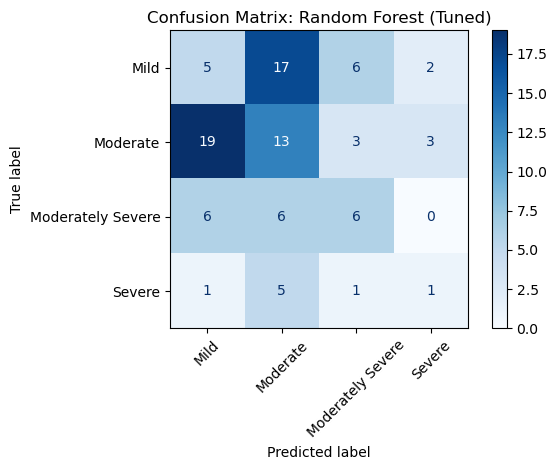

Test ROC-AUC (OvR, macro): 0.556


In [10]:
# Evaluate on test set using best estimator
best_rf_model = grid_rf.best_estimator_
y_pred_rf = best_rf_model.predict(X_test_cls)
y_proba_rf = best_rf_model.predict_proba(X_test_cls)

# Classification report
print(classification_report(y_test_cls, y_pred_rf))

# Confusion matrix
cm_rf = confusion_matrix(y_test_cls, y_pred_rf, labels=best_rf_model.classes_)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=best_rf_model.classes_)
disp_rf.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix: Random Forest (Tuned)")
plt.tight_layout()
plt.show()

# ROC-AUC (OvR, macro average)
auc_score_rf = roc_auc_score(y_test_cls, y_proba_rf, multi_class="ovr", average="macro")
print(f"Test ROC-AUC (OvR, macro): {auc_score_rf:.3f}")


### Random Forest Performance Summary

The Random Forest model, tuned with 100 trees and max depth of 10, showed:

- Accuracy: 0.27
- Weighted F1 Score: 0.27
- ROC-AUC (macro average): 0.556

While the model improved recall for moderately severe and severe depression compared to logistic regression, its overall precision and accuracy were lower. This may reflect challenges with class imbalance and overlapping features. The Random Forest remains valuable for interpreting feature importance, but did not outperform other models in overall predictive accuracy.


### Support Vector Machine (Classification)

Support Vector Machines (SVM) are margin-based classifiers that can handle complex, nonlinear decision boundaries when combined with kernel functions. They are robust to overfitting in high-dimensional spaces but can be sensitive to hyperparameter settings. The model is tuned using stratified 5-fold cross-validation, and performance is evaluated on a held-out test set.


In [11]:
from sklearn.svm import SVC

# Pipeline with scaler and SVC
svm_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(probability=True, random_state=42))
])

# Define parameter grid for SVM
param_grid_svm = {
    "svm__C": [0.01, 0.1, 1, 5, 10],          # controls margin tightness vs. misclassification
    "svm__kernel": ["linear", "rbf"],         # linear for interpretability, rbf for flexibility
    "svm__gamma": ["scale", 0.01, 0.001],     # only used with rbf, affects decision curve shape
    "svm__class_weight": [None, "balanced"]   # adjusts for class imbalance
}

# GridSearchCV
grid_svm = GridSearchCV(
    estimator=svm_pipeline,
    param_grid=param_grid_svm,
    cv=cv,
    scoring="f1_weighted",
    n_jobs=-1
)

# Fit grid search on training data
grid_svm.fit(X_train_cls, y_train_cls)

# Best parameters
print("Best SVM Params:", grid_svm.best_params_)


Best SVM Params: {'svm__C': 5, 'svm__class_weight': None, 'svm__gamma': 'scale', 'svm__kernel': 'linear'}


                   precision    recall  f1-score   support

             Mild       0.29      0.33      0.31        30
         Moderate       0.35      0.42      0.38        38
Moderately Severe       0.18      0.11      0.14        18
           Severe       0.00      0.00      0.00         8

         accuracy                           0.30        94
        macro avg       0.20      0.22      0.21        94
     weighted avg       0.27      0.30      0.28        94



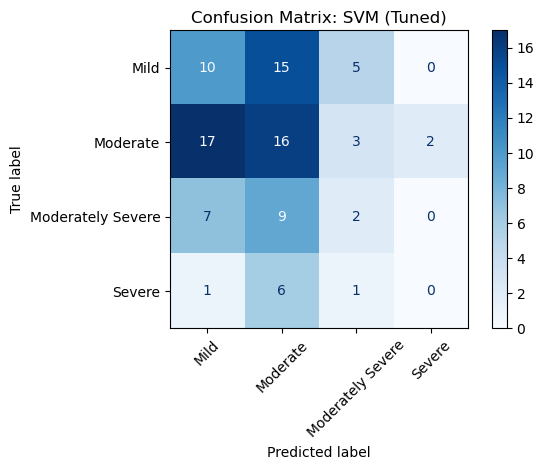

Test ROC-AUC (OvR, macro): 0.541


In [12]:
# Evaluate on test set using best estimator
best_svm_model = grid_svm.best_estimator_
y_pred_svm = best_svm_model.predict(X_test_cls)
y_proba_svm = best_svm_model.predict_proba(X_test_cls)

# Classification report
print(classification_report(y_test_cls, y_pred_svm))

# Confusion matrix
cm_svm = confusion_matrix(y_test_cls, y_pred_svm, labels=best_svm_model.classes_)
disp_svm = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=best_svm_model.classes_)
disp_svm.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix: SVM (Tuned)")
plt.tight_layout()
plt.show()

# ROC-AUC (OvR, macro average)
auc_score_svm = roc_auc_score(y_test_cls, y_proba_svm, multi_class="ovr", average="macro")
print(f"Test ROC-AUC (OvR, macro): {auc_score_svm:.3f}")


### Support Vector Machine (SVM) Performance Summary

The best SVM model used a linear kernel, `C=5`, and default gamma (`scale`). Results were:

- **Accuracy**: 0.30  
- **Weighted F1 Score**: 0.28  
- **ROC-AUC (macro average)**: 0.541

The SVM model outperformed Logistic Regression in recall for Moderate cases but still misclassified most Severe cases. It correctly identified some instances of each class, but precision dropped as severity increased. The linear kernel maintained interpretability, though future work may explore RBF or polynomial kernels for more flexible boundaries.


## Model Performance Summary

### Classification Models

| Model                | CV Accuracy | CV F1 (Weighted) | CV ROC-AUC (OvR) | Test Accuracy | Test F1 (Weighted) | Test ROC-AUC (OvR) |
|----------------------|-------------|------------------|------------------|---------------|--------------------|--------------------|
| Logistic Regression   | 0.386 ± 0.040 | 0.361 ± 0.047   | 0.619 ± 0.009    | 0.32          | 0.29               | 0.563              |
| Random Forest         | 0.362 ± 0.039 | 0.323 ± 0.046   | 0.584 ± 0.026    | 0.27          | 0.27               | 0.556              |
| SVM (Linear)          | 0.376 ± 0.049 | 0.342 ± 0.054   | 0.628 ± 0.024    | 0.30          | 0.28               | 0.541              |


The logistic regression model achieved the highest test accuracy and ROC-AUC, performing best at distinguishing mild to moderate depression cases. The SVM model showed slightly better recall for moderate cases, while the Random Forest model improved recall for more severe categories but had lower overall accuracy and ROC-AUC. These results suggest that no single model dominates all aspects of prediction; each exhibits distinct strengths and weaknesses. Feature importance is presented from the Random Forest model because of its ability to capture nonlinear interactions and provide interpretable feature rankings.


### Feature Importance: Random Forest

The Random Forest model highlights which features had the greatest influence on predicting depression severity. The top 15 features are ranked by their average decrease in impurity across trees in the ensemble.

Notable features include:

- **Age in years at screening** and **Monthly poverty index**, which consistently ranked highest.
- **Sleep-related variables** for both weekdays and weekends, suggesting the role of rest in depression severity.
- **Perceived anxiety**, **education level**, and **household size**, all of which have established links to mental health outcomes.
- **Access to care variables**, including insurance coverage and routine healthcare usage.

These results reinforce the multidimensional nature of depression and suggest that both social and behavioral health factors play key roles in its severity. The model's transparency supports ethical reporting and potential use in public health decision-making.


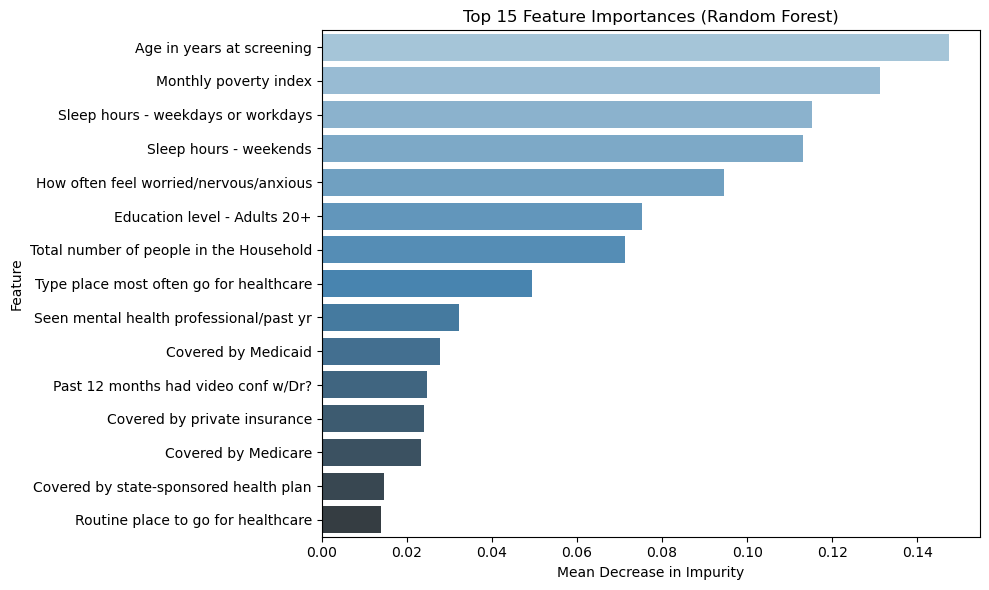

In [13]:
# Extract feature importances from final Random Forest model
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Get importances from the fitted model directly
importances = best_rf_model.feature_importances_
feature_names = X.columns

# Build DataFrame
feat_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values("Importance", ascending=False)

# Plot top 15
plt.figure(figsize=(10, 6))
sns.barplot(data=feat_df.head(15), x="Importance", y="Feature", palette="Blues_d")
plt.title("Top 15 Feature Importances (Random Forest)")
plt.xlabel("Mean Decrease in Impurity")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


### Sensitivity Analysis: Socioeconomic Predictors Only

A sensitivity analysis was conducted to assess how well the model performs when limited to socioeconomic variables commonly available in administrative records. This helps isolate the impact of financial and insurance-related predictors on depression severity classification.

The same Random Forest configuration was used to ensure comparability. Model performance on the test set is presented below.


                   precision    recall  f1-score   support

             Mild       0.30      0.20      0.24        30
         Moderate       0.39      0.39      0.39        38
Moderately Severe       0.24      0.33      0.28        18
           Severe       0.09      0.12      0.11         8

         accuracy                           0.30        94
        macro avg       0.26      0.26      0.25        94
     weighted avg       0.31      0.30      0.30        94



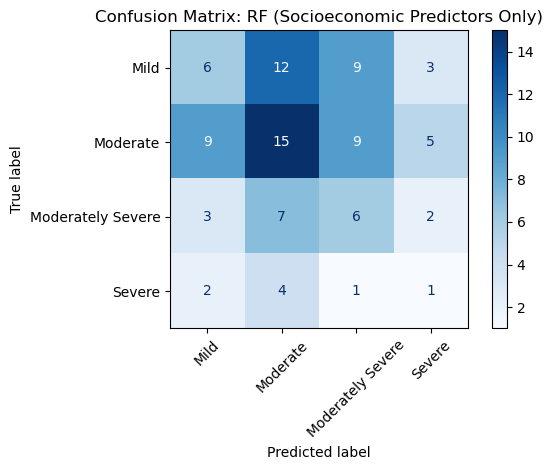

Test ROC-AUC (OvR, macro): 0.487


In [14]:
# Define subset of socioeconomic predictors
socioeconomic_vars = [
    "Monthly poverty index",
    "Education level - Adults 20+",
    "Covered by health insurance",
    "Covered by private insurance",
    "Covered by Medicare",
    "Covered by Medi-Gap",
    "Covered by Medicaid",
    "Covered by military health care",
    "Covered by state-sponsored health plan",
    "Time when no insurance in past year?"
]

# Create new X matrix
X_ses = df[socioeconomic_vars]

# Split again using the same stratified approach
X_train_ses, X_test_ses, y_train_ses, y_test_ses = train_test_split(
    X_ses, y_cls, test_size=0.2, random_state=42, stratify=y_cls
)

# Use same best parameters from tuned full model
rf_ses = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=1,
    class_weight="balanced_subsample",
    bootstrap=True,
    random_state=42
)

# Fit and evaluate
rf_ses.fit(X_train_ses, y_train_ses)
y_pred_ses = rf_ses.predict(X_test_ses)
y_proba_ses = rf_ses.predict_proba(X_test_ses)

# Print classification report
print(classification_report(y_test_ses, y_pred_ses))

# Confusion matrix
cm_ses = confusion_matrix(y_test_ses, y_pred_ses, labels=rf_ses.classes_)
disp_ses = ConfusionMatrixDisplay(confusion_matrix=cm_ses, display_labels=rf_ses.classes_)
disp_ses.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix: RF (Socioeconomic Predictors Only)")
plt.tight_layout()
plt.show()

# ROC-AUC
roc_auc_ses = roc_auc_score(y_test_ses, y_proba_ses, multi_class="ovr", average="macro")
print(f"Test ROC-AUC (OvR, macro): {roc_auc_ses:.3f}")


### Sensitivity Analysis Results

When restricted to socioeconomic predictors only, model performance declined compared to the full-featured Random Forest model.

- **Test Accuracy:** 0.30  
- **Weighted F1 Score:** 0.30  
- **ROC-AUC (macro average):** 0.487

The model showed some ability to separate Mild and Moderate cases but struggled to correctly identify the more severe PHQ-9 categories. Severe cases were frequently misclassified or missed altogether.

This result suggests that while socioeconomic variables carry meaningful information, they are not sufficient by themselves for accurate classification. Behavioral and clinical features, such as sleep patterns and anxiety levels, appear essential for identifying higher-risk individuals.

These findings support the use of a broader feature set when building models to inform mental health screening and decision-making in public health.


## Failure Analysis

To evaluate where the tuned Random Forest classifier struggles most, a structured failure analysis was conducted. This section identifies three distinct types of prediction errors, using representative cases from the test set. Each case highlights a specific limitation of the model and offers insight into where targeted improvements may be needed.

### 1. Adjacent Class Confusion

**Type:** Misclassification between neighboring PHQ-9 severity levels  
**Why it matters:** These errors occur when the model cannot clearly distinguish between categories like Mild and Moderate, even when differences are clinically meaningful.

- **Example:** Row 328 - Labeled **Mild**, Predicted **Moderate**  
  A 63-year-old individual with regular insurance, moderate sleep, and no extreme feature values. Despite stable conditions, the model predicted one level higher.

- **Possible Cause:** Subtle feature overlap near PHQ-9 score thresholds  
- **Potential Fix:** Consider using ordinal classification techniques or smoothing methods for severity categories

---

### 2. Underprediction of Severe Cases

**Type:** Systematic underprediction of high-risk individuals  
**Why it matters:** These errors are especially concerning in health screening. Failing to identify Severe or Moderately Severe cases may delay access to support or care.

- **Example:** Row 455 - Labeled **Severe**, Predicted **Moderate**  
  An 18-year-old with no regular provider, high poverty, and limited healthcare access. The model did not detect the severity of their risk profile.

- **Possible Cause:** Class imbalance or conservative decision thresholds  
- **Potential Fix:** Adjust class weights or explore ensemble models that specialize in minority class prediction

---

### 3. Mismatches with Risk Profiles

**Type:** Predictions that conflict with known risk indicators  
**Why it matters:** The model assigned Mild or Moderate labels to individuals with multiple established depression risk factors.

- **Example:** Row 104 - Labeled **Moderate**, Predicted **Mild**  
  A 43-year-old with very limited sleep (3.5 hours), no routine care, and prior mental health issues. Despite these signs, the model underpredicted their severity.

- **Possible Cause:** Important features may be overshadowed by more dominant patterns during training  
- **Potential Fix:** Investigate feature importance using SHAP or LIME and consider engineering interaction terms

---

### Ethical Framing

Failure analysis is essential when working with mental health data. Misclassifying high-risk individuals or overlooking key indicators can lead to serious harm. This analysis underscores the importance of transparent methods, class-aware tuning strategies, and critical evaluation of model behavior.


In [15]:
# Refit best Random Forest model to full training data
best_rf_model.fit(X_train_cls, y_train_cls)

# Predict on test data
y_pred_rf = best_rf_model.predict(X_test_cls)

# Create a comparison DataFrame
failures_df = X_test_cls.copy()
failures_df["True Label"] = y_test_cls.values
failures_df["Predicted Label"] = y_pred_rf
failures_df["Correct"] = failures_df["True Label"] == failures_df["Predicted Label"]

# Filter for misclassified cases
misclassified_rf = failures_df[~failures_df["Correct"]]

# Display a few misclassified cases for inspection
misclassified_rf.head(10)


,Age in years at screening,Monthly poverty index,Total number of people in the Household,Education level - Adults 20+,Covered by health insurance,Covered by private insurance,Covered by Medicare,Covered by Medi-Gap,Covered by Medicaid,Covered by military health care,...,Seen mental health professional/past yr,Past 12 months had video conf w/Dr?,Routine place to go for healthcare,Type place most often go for healthcare,Sleep hours - weekdays or workdays,Sleep hours - weekends,How often feel worried/nervous/anxious,True Label,Predicted Label,Correct
5,36,1.865,5,4,1,0,0,0,0,0,...,1,0,1,3,7.5,7.5,1,Moderate,Severe,False
223,71,2.650,1,4,1,1,1,0,0,0,...,0,0,1,1,6.5,6.5,2,Moderate,Mild,False
417,59,5.000,5,5,0,0,0,0,0,0,...,0,1,1,1,6.0,10.0,1,Moderately Severe,Moderate,False
328,63,4.120,1,4,1,1,0,0,0,0,...,1,0,1,1,6.5,5.5,2,Mild,Moderate,False
347,64,1.980,3,3,1,0,0,0,0,0,...,0,0,1,2,7.5,8.0,2,Mild,Moderate,False
351,44,1.990,2,4,1,1,0,0,0,0,...,0,0,1,1,8.5,10.5,2,Moderate,Mild,False
170,21,1.865,1,5,1,1,0,0,0,0,...,1,1,1,2,8.0,8.0,1,Mild,Severe,False
455,18,5.000,3,0,1,1,0,0,0,0,...,1,0,0,0,8.0,8.0,1,Severe,Moderate,False
104,43,2.080,3,3,1,1,0,0,0,0,...,0,0,1,3,3.5,6.0,4,Mild,Moderate,False
464,51,4.800,5,4,1,1,0,0,0,0,...,0,0,1,1,7.5,8.5,4,Mild,Moderate,False


### SHAP Explanation for Misclassified Cases

To supplement the failure analysis, SHAP (SHapley Additive exPlanations) was used to interpret the Random Forest model’s predictions on misclassified test samples. SHAP assigns each feature a contribution value for a specific prediction, allowing insight into what pushed a case toward an incorrect class.

This method was applied to a subset of misclassified records. For each case, SHAP helps reveal how individual features influenced the model’s output relative to the base expectation.



Case 1: True Label = Moderate, Predicted Label = Severe


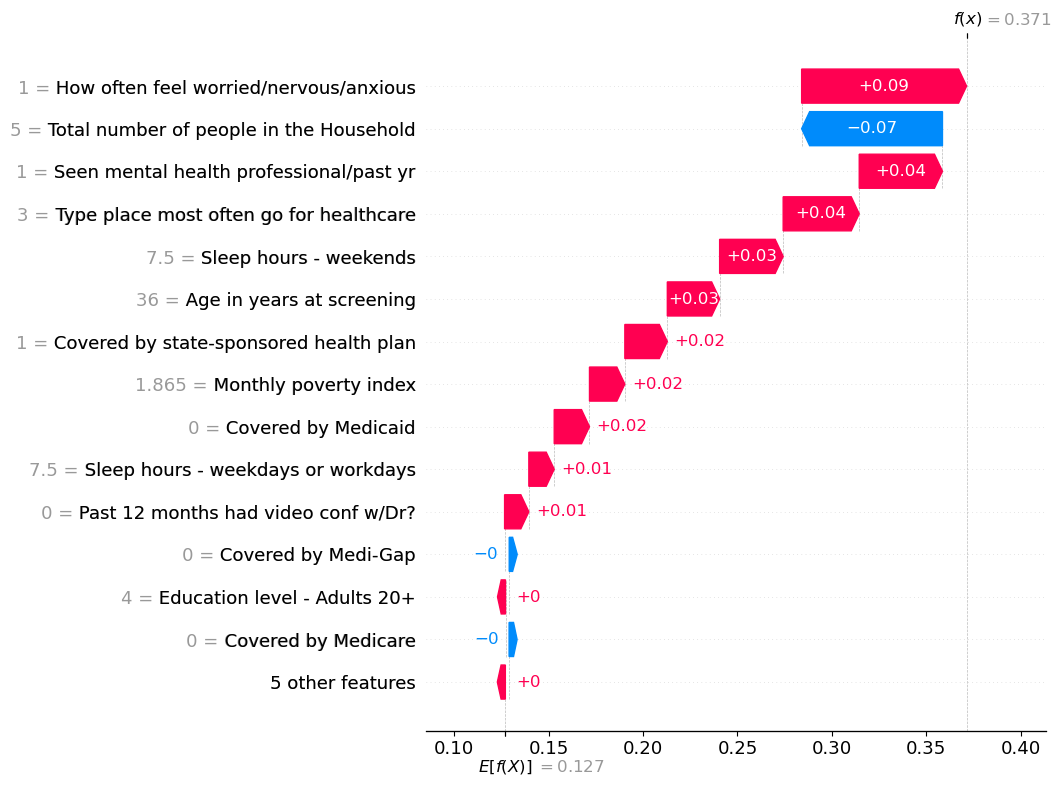


Case 2: True Label = Moderate, Predicted Label = Mild


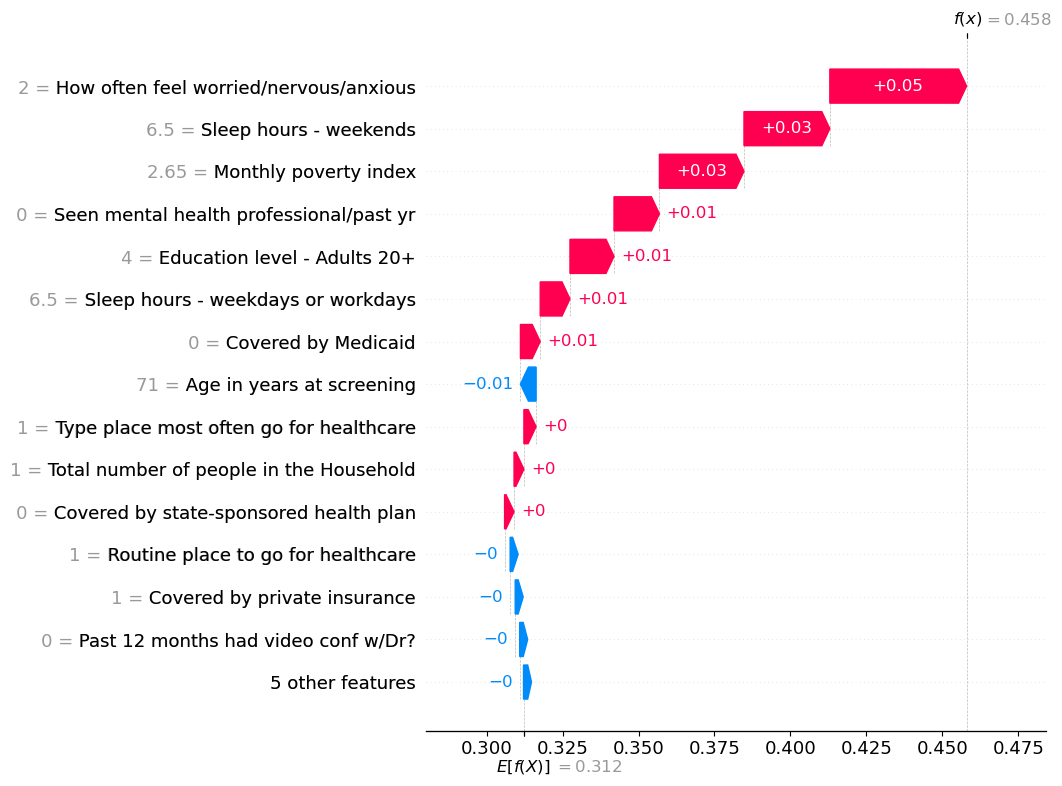


Case 3: True Label = Moderately Severe, Predicted Label = Moderate


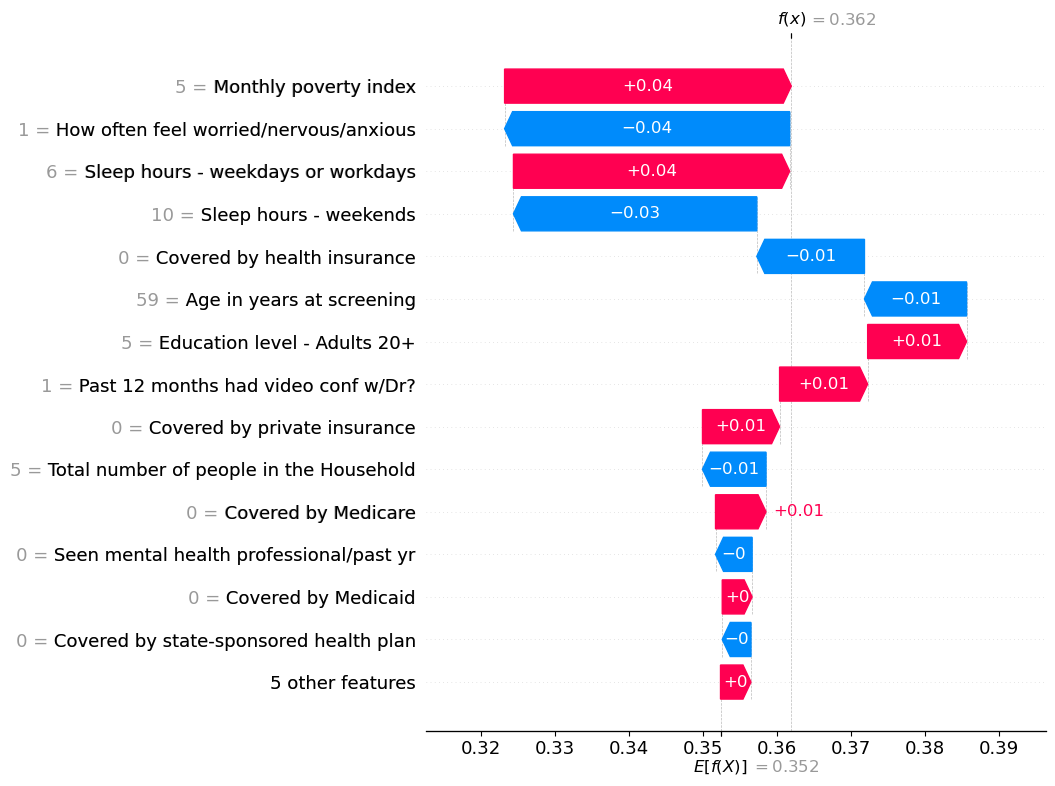

In [16]:
import shap
import matplotlib.pyplot as plt

# Fit best model (if not already)
best_rf_model.fit(X_train_cls, y_train_cls)

# Create SHAP explainer
explainer = shap.Explainer(best_rf_model, X_train_cls)

# Subset to misclassified examples and drop labels
X_misclassified = misclassified_rf.drop(columns=["True Label", "Predicted Label", "Correct"])

# Compute SHAP values
shap_values = explainer(X_misclassified)

# Loop through the first 3 misclassified cases
for i in range(3):
    true_label = misclassified_rf.iloc[i]["True Label"]
    predicted_label = misclassified_rf.iloc[i]["Predicted Label"]
    predicted_class_index = list(best_rf_model.classes_).index(predicted_label)
    
    # Prepare SHAP explanation for the predicted class
    sv = shap_values[i]
    sv.values = shap_values.values[i][:, predicted_class_index]
    sv.base_values = shap_values.base_values[i][predicted_class_index]
    sv.data = shap_values.data[i]

    # Title and plot
    print(f"\nCase {i+1}: True Label = {true_label}, Predicted Label = {predicted_label}")
    shap.plots.waterfall(sv, max_display=15, show=True)


### SHAP Interpretation Summaries

**Case 1**  
**True Label:** Moderate  
**Predicted Label:** Severe  
The model overestimated severity. Features like high reported anxiety and prior mental health visits drove the prediction upward, outweighing more moderate indicators such as stable sleep patterns and insurance coverage.

**Case 2**  
**True Label:** Moderate  
**Predicted Label:** Mild  
Here the model underestimated severity. Weekend sleep hours, poverty index, and anxiety levels contributed modestly, but several risk indicators such as age and health access did not tip the decision higher.

**Case 3**  
**True Label:** Moderately Severe  
**Predicted Label:** Moderate  
This borderline case showed SHAP contributions spread across many features. Though some risk signals (e.g., limited insurance, sleep hours) pushed the score upward, others like household size and anxiety fell just short of shifting the prediction into the higher severity tier.

These SHAP insights help explain where and why the model may fail to catch subtleties in depression severity, suggesting that post-hoc interpretation can guide feature refinement and threshold adjustments in future iterations.


In [17]:
import joblib
import os

# Create models directory if it doesn't exist
#os.makedirs("models", exist_ok=True)

# Save best estimators
#joblib.dump(best_logreg_model, "models/best_logreg_alexis.pkl")
#joblib.dump(best_rf_model, "models/best_rf_alexis.pkl")
#joblib.dump(best_svm_model, "models/best_svm_alexis.pkl")
